## Четвертое решение
В этом решении предлагается в функцию потерь передавать взвешивание по классам, чтобы модель делала акценты на редких объектах и не подгонялась под часто встречаемые.

In [1]:
import re
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from itertools import chain
from torch import nn, optim
import albumentations as albu
from collections import Counter
import matplotlib.pyplot as plt
from catalyst.metrics import iou
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from catalyst.contrib.losses import DiceLoss, IoULoss
from albumentations.pytorch import ToTensorV2 as ToTensor
from catalyst.callbacks import (DiceCallback, 
                                IOUCallback, 
                                CriterionCallback,
                                MetricAggregationCallback, 
                                OptimizerCallback)
from utils import(create_sample, 
                  extract_ids, 
                  split_sample, 
                  PascalDataset, 
                  visualize, 
                  PascalRunner,
                  plot_metric,
                  extract_masks, 
                  extract_masks_label)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
src_path = Path("Pascal-part")
image_path = src_path / "JPEGImages"
mask_path = src_path / "gt_masks"

image_names = create_sample(image_path)
mask_names = create_sample(mask_path)

In [4]:
train_ids = extract_ids(src_path / "train_id.txt")
val_ids = extract_ids(src_path / "val_id.txt")

image_names_train, image_names_val = split_sample(image_names, train_ids, val_ids)
mask_names_train, mask_names_val = split_sample(mask_names, train_ids, val_ids)

In [5]:
classes = []
with open(src_path / "classes.txt") as file:
    for line in file:
        classes.append(re.sub("[^a-z_]+", "", line))

classes

['bg', 'low_hand', 'torso', 'low_leg', 'head', 'up_leg', 'up_hand']

Чтобы избежать переобучения на обучающей выборке добавим аугментацию изображений:

In [6]:
p = 0.3
image_size = 224
n_classes = len(classes)

train_transforms = albu.Compose([
    albu.RandomResizedCrop(image_size, image_size),
    albu.Rotate(p=p),
    albu.HorizontalFlip(p=p),
    albu.VerticalFlip(p=p), 
    albu.GaussianBlur(p=p),
    albu.Normalize(),
    ToTensor()
])

val_transforms = albu.Compose([
    albu.Resize(image_size, image_size),
    albu.Normalize(),
    ToTensor()
])

train_dataset = PascalDataset(image_names_train, mask_names_train, n_classes, train_transforms)
val_dataset = PascalDataset(image_names_val, mask_names_val, n_classes, val_transforms)

In [7]:
label_counter = Counter()

for mask in train_dataset.masks:
    label_counter.update(mask.flatten())

Посмотрим на попиксельное распределение между классами:

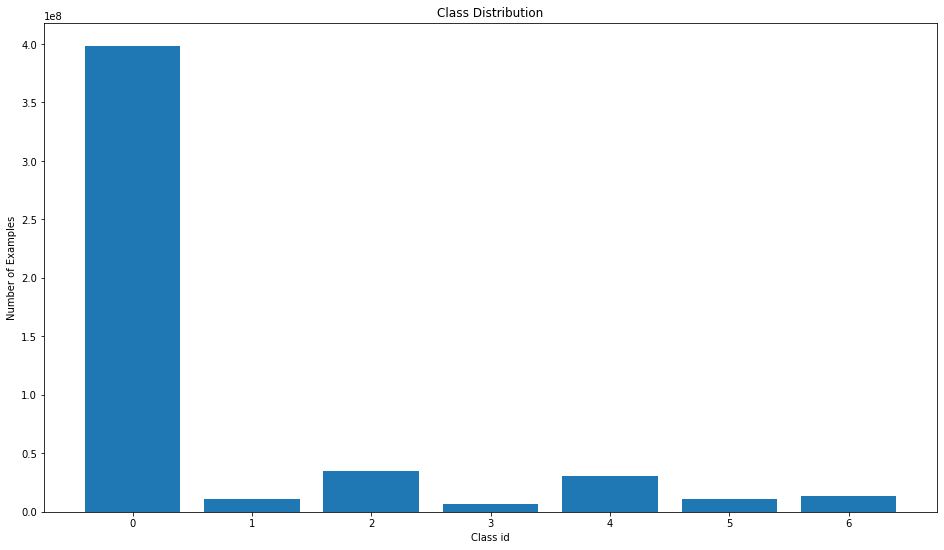

In [8]:
plt.figure(figsize=(16, 9))
plt.title("Сlass Distribution")
plt.ylabel("Number of Examples")
plt.xlabel("Class id")
plt.bar(label_counter.keys(), label_counter.values())
plt.show()

Как и ожилась, присутствует сильный дисбаланс, поэтому будем применять взвешивание по [данной стратегии](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html#sklearn-utils-class-weight-compute-class-weight):

In [9]:
counts_sorted = sorted(label_counter.items(), key=lambda x: x[0])
label_counts = list(map(lambda x: x[1], counts_sorted))
n_samples = sum(label_counts)

class_weights = torch.FloatTensor([n_samples / (n_classes * label_count) for label_count in label_counts]).to(device)
class_weights

tensor([ 0.1813,  6.5277,  2.0799, 11.0395,  2.3868,  6.3662,  5.4128],
       device='cuda:0')

Примеры исходных изображений с аугментацией:

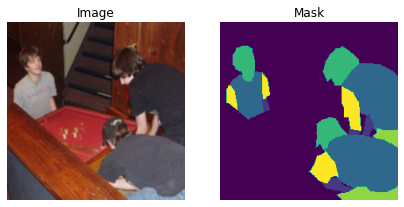

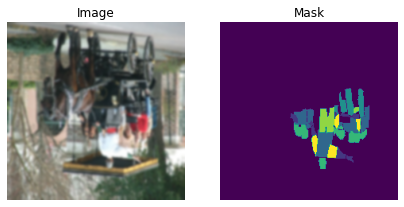

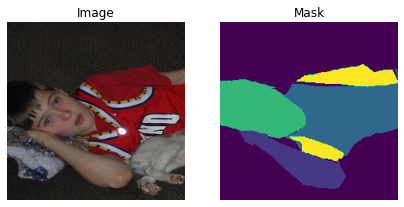

In [10]:
np.random.seed(42)
n_examples = 3
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

for i in range(n_examples):
    image, mask, mask_expanded = np.random.choice(train_dataset).values()
    image = image.permute(1, 2, 0)
    image = image * std + mean
    visualize(image=image, mask=mask)

In [11]:
num_epochs = 20
batch_size = 32
num_workers = 2
threshold = 0.5
logdir = "./logs/segmentation"

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
loaders = {
    "train": train_dataloader,
    "valid": val_dataloader
}
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "ce": nn.CrossEntropyLoss(class_weights)
}
model = smp.Unet("resnet50", classes=n_classes, activation=nn.Softmax2d)
optimizer = optim.Adam(
    (
        {
            "params": model.encoder.parameters(),
            "lr": 1e-4,
        },
        {
            "params": chain(model.decoder.parameters(), model.segmentation_head.parameters()),
            "lr" : 1e-2
        }
     )
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
callbacks = [
    CriterionCallback("pred", "mask_expanded", "loss_dice", "dice"),
    CriterionCallback("pred", "mask_expanded", "loss_iou", "iou"),
    CriterionCallback("pred", "mask", "loss_ce", "ce"),
    MetricAggregationCallback(
        "loss",
        {"loss_dice": 0.9, "loss_iou": 1.0, "loss_ce": 0.8},
        "weighted_sum"
        ),
    DiceCallback("pred", "mask_expanded", class_names=classes, threshold=threshold),
    IOUCallback("pred", "mask_expanded", class_names=classes, threshold=threshold),
    OptimizerCallback("loss")
]
runner = PascalRunner(input_key="image", output_key="pred",
                      output_mask_key="pred_mask", target_key="mask", 
                      device=device)

In [12]:
runner.train(
    loaders=loaders,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    callbacks=callbacks,
    num_epochs=num_epochs,
    logdir=logdir,
    valid_loader="valid",
    valid_metric="iou",
    minimize_valid_metric=False
)

train (1/20) dice: 0.3829100430011749 | dice/_macro: 0.3829100430011749 | dice/_micro: 0.7499740123748779 | iou: 0.2802956700325012 | iou/_macro: 0.2802956700325012 | iou/_micro: 0.5999667048454285 | loss: 2.706915855407715 | loss_ce: 1.747242157120108 | loss_ce/mean: 1.747242157120108 | loss_ce/std: 0.0832973759235997 | loss_dice: 0.6415215281839499 | loss_dice/mean: 0.6415215281839499 | loss_dice/std: 0.0949767505316242 | loss_iou: 0.731752612113278 | loss_iou/mean: 0.731752612113278 | loss_iou/std: 0.0756741689282445 | lr: 0.0001 | momentum: 0.9
valid (1/20) dice: 0.5129534006118774 | dice/_macro: 0.5129534006118774 | dice/_micro: 0.8229576349258423 | iou: 0.3896608352661133 | iou/_macro: 0.3896608352661133 | iou/_micro: 0.6991742253303528 | loss: 2.3601784706115723 | loss_ce: 1.6017575402239594 | loss_ce/mean: 1.6017575402239594 | loss_ce/std: 0.03043272611149419 | loss_dice: 0.504934288487576 | loss_dice/mean: 0.504934288487576 | loss_dice/std: 0.027518938794700413 | loss_iou: 0.6

In [13]:
csv_logger = Path(logdir) / "csv_logger"

train_df = pd.read_csv(csv_logger / "train.csv")
valid_df = pd.read_csv(csv_logger / "valid.csv")

Значения функции потерь и ключевой метрики во время обучения:

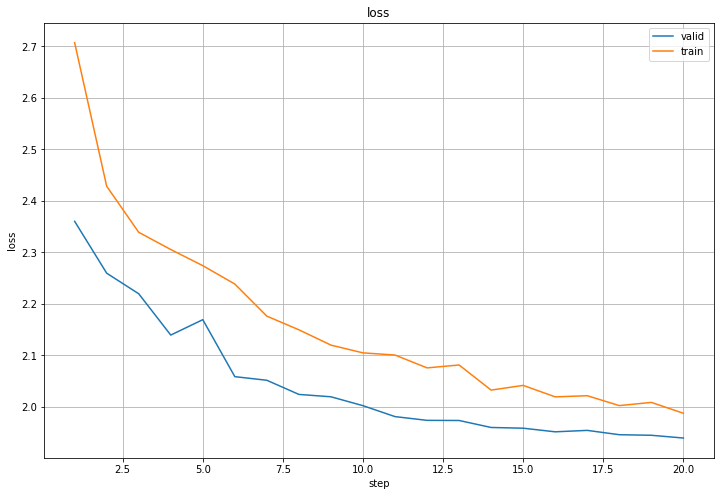

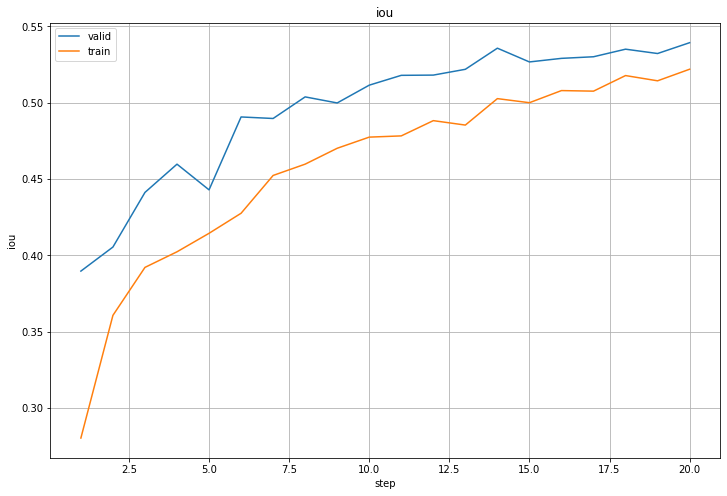

In [14]:
for metric_name in ["loss", "iou"]:
    plot_metric(train_df, valid_df, metric_name)

Почти на всем этапе обучение значение функции потерь уменьшается, а значение ключевой метрики увеличивается на обеих выборках.

Примеры исходных изображений и предсказаний модели на валидационной выборке:

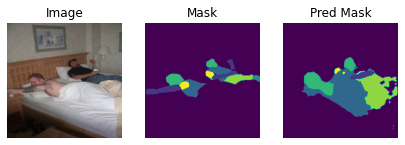

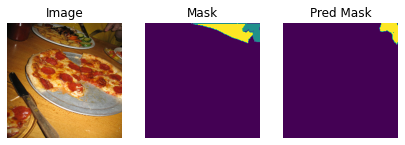

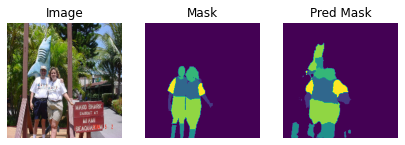

In [15]:
np.random.seed(42)

for i in range(n_examples):
    data = np.random.choice(val_dataset)
    dl = DataLoader([data])
    image, mask, mask_expanded = data.values()
    image = image.permute(1, 2, 0)
    image = image * std + mean
    pred_mask = torch.cat(list(runner.predict_loader(dl))).cpu().squeeze()
    visualize(image=image, mask=mask, pred_mask=pred_mask)

In [16]:
true_masks = torch.cat(list(extract_masks(val_dataloader))).to(device)
predicted_masks = torch.cat(list(runner.predict_loader(val_dataloader)))

In [17]:
body_labels = [[1, 6, 2, 4, 3, 5]]
up_low_labels = [[1, 6, 2, 4], [3, 5]]
parts_labels = list(range(1, n_classes))

true_masks0 = torch.stack(list(extract_masks_label(true_masks, body_labels)))
true_masks1 = torch.stack(list(extract_masks_label(true_masks, up_low_labels)))
true_masks2 = torch.stack(list(extract_masks_label(true_masks, parts_labels)))

predicted_masks0 = torch.stack(list(extract_masks_label(predicted_masks, body_labels)))
predicted_masks1 = torch.stack(list(extract_masks_label(predicted_masks, up_low_labels)))
predicted_masks2 = torch.stack(list(extract_masks_label(predicted_masks, parts_labels)))

Итоговые значения метрик на валидационной выборке:

In [18]:
iou0 = dict(zip(["body"], iou(true_masks0, predicted_masks0).cpu().numpy().round(3)))
pd.DataFrame(iou0, index=["iou0"])

,body
iou0,0.763


In [19]:
iou1 = dict(zip(["upper_body", "lower_body"], iou(true_masks1, predicted_masks1).cpu().numpy().round(3)))
pd.DataFrame(iou1, index=["iou1"])

,upper_body,lower_body
iou1,0.768,0.441


In [20]:
iou2 = dict(zip(classes[1:], iou(true_masks2, predicted_masks2).cpu().numpy().round(3)))
pd.DataFrame(iou2, index=["iou2"])

,low_hand,torso,low_leg,head,up_leg,up_hand
iou2,0.414,0.547,0.33,0.804,0.349,0.407


## Вывод:
Данное решение так же имеет хорошее качество, но значительного прироста по метрикам не наблюдается.